In [27]:
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
iTransf_n_windows = [10, 20, 30, 40, 50, 60, 70] #, 80, 90, 100, 200, 500, 1000, 2000]
TranAD_n_windows = [10, 20, 30, 40, 50, 60, 70]

In [33]:
TranAD_all_res = {'ROC/AUC': [], 'f1': []}
for i in TranAD_n_windows:
    path = f'studies/TranAD_SMAP/n_window{i}/results'
    df_res = pd.read_csv(f'{path}/all_res.csv')
    # print(df_res)
    TranAD_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])

print(TranAD_all_res)

{'ROC/AUC': [0    0.989816
Name: ROC/AUC, dtype: float64, 0    0.988655
Name: ROC/AUC, dtype: float64, 0    0.989622
Name: ROC/AUC, dtype: float64, 0    0.988849
Name: ROC/AUC, dtype: float64, 0    0.988204
Name: ROC/AUC, dtype: float64, 0    0.987882
Name: ROC/AUC, dtype: float64, 0    0.987753
Name: ROC/AUC, dtype: float64], 'f1': [0    0.904469
Name: f1, dtype: float64, 0    0.894732
Name: f1, dtype: float64, 0    0.902831
Name: f1, dtype: float64, 0    0.89634
Name: f1, dtype: float64, 0    0.891002
Name: f1, dtype: float64, 0    0.888356
Name: f1, dtype: float64, 0    0.887302
Name: f1, dtype: float64]}


In [34]:
iTransf_all_res = {'ROC/AUC': [], 'f1': []}
for i in iTransf_n_windows:
    path = f'studies/iTransformer_SMAP/n_window{i}/results'
    df_res = pd.read_csv(f'{path}/all_res.csv')
    # print(df_res)
    iTransf_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    iTransf_all_res['f1'].append(df_res['f1'])

print(iTransf_all_res)

{'ROC/AUC': [0    0.988011
Name: ROC/AUC, dtype: float64, 0    0.984852
Name: ROC/AUC, dtype: float64, 0    0.98279
Name: ROC/AUC, dtype: float64, 0    0.980211
Name: ROC/AUC, dtype: float64, 0    0.97976
Name: ROC/AUC, dtype: float64, 0    0.975764
Name: ROC/AUC, dtype: float64, 0    0.975055
Name: ROC/AUC, dtype: float64], 'f1': [0    0.889412
Name: f1, dtype: float64, 0    0.864235
Name: f1, dtype: float64, 0    0.848549
Name: f1, dtype: float64, 0    0.829723
Name: f1, dtype: float64, 0    0.826514
Name: f1, dtype: float64, 0    0.79914
Name: f1, dtype: float64, 0    0.794472
Name: f1, dtype: float64]}


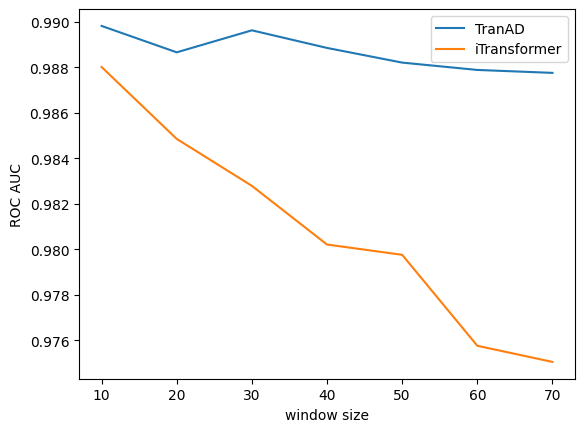

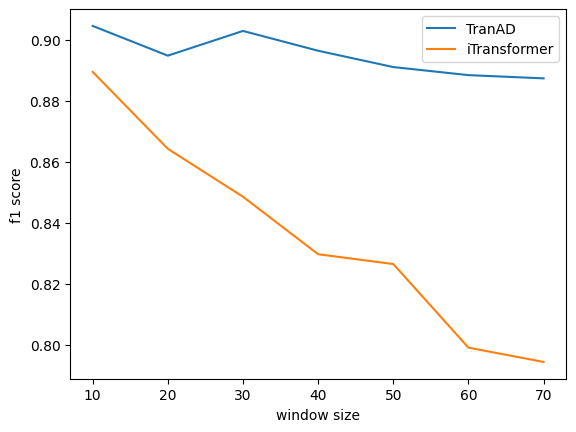

In [35]:
plt.plot(TranAD_n_windows, TranAD_all_res['ROC/AUC'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['ROC/AUC'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

plt.plot(TranAD_n_windows, TranAD_all_res['f1'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['f1'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.legend()
plt.show()